## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
from tensorflow import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 128, 64], 
              kernel_regularizer=l2(1e-4), drp_ratio=0.2, use_bn=True):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=kernel_regularizer)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=kernel_regularizer)(x)
        if drp_ratio != None:
            x = Dropout(drp_ratio)(x)
        if use_bn !=None:
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 30 # 50
BATCH_SIZE = 512
MOMENTUM = 0.95

SETTINGS = {}
SETTINGS["regularizer=l2(1e-4), w/o dropout, w/o BN"] = [l2(1e-4), None, None]
SETTINGS["regularizer=l2(1e-2), w/o dropout, w/o BN"] = [l2(1e-2), None, None]
SETTINGS["regularizer=l2(1e-4), w/  dropout, w/o BN"] = [l2(1e-4),  0.2, None]
SETTINGS["regularizer=l2(1e-2), w/  dropout, w/o BN"] = [l2(1e-2),  0.2, None]
SETTINGS["regularizer=l2(1e-4), w/o dropout, w/  BN"] = [l2(1e-4), None, True]
SETTINGS["regularizer=l2(1e-2), w/o dropout, w/  BN"] = [l2(1e-2), None, True]
SETTINGS["regularizer=l2(1e-4), w/  dropout, w/  BN"] = [l2(1e-4),  0.2, True]
SETTINGS["regularizer=l2(1e-2), w/  dropout, w/  BN"] = [l2(1e-2),  0.2, True]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for key in SETTINGS.keys():
    SETTING = SETTINGS[key]
    # Train
    print("--------------- Train [%s] --------------" % key)
    model = build_mlp(input_shape=x_train.shape[1:], 
                      kernel_regularizer=SETTING[0], 
                      drp_ratio=SETTING[1], 
                      use_bn=SETTING[2])
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    result = {}
    result["loss"] = model.history.history["loss"]
    result["val_loss"] = model.history.history["val_loss"]
    result["accuracy"] = model.history.history["accuracy"]
    result["val_accuracy"] = model.history.history["val_accuracy"]
    results[key] = result

--------------- Train [regularizer=l2(1e-4), w/o dropout, w/o BN] --------------


W0720 17:44:03.950214  8500 deprecation.py:323] From c:\users\qwerz\miniconda3\envs\ml100\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 3s 59us/sample - loss: 2.2760 - accuracy: 0.1900 - val_loss: 2.1461 - val_accuracy: 0.2502
Epoch 2/30
50000/50000 [==============================] - 2s 45us/sample - loss: 2.0673 - accuracy: 0.2832 - val_loss: 2.0089 - val_accuracy: 0.3155
Epoch 3/30
50000/50000 [==============================] - 2s 45us/sample - loss: 1.9701 - accuracy: 0.3295 - val_loss: 1.9379 - val_accuracy: 0.3505
Epoch 4/30
50000/50000 [==============================] - 2s 45us/sample - loss: 1.9098 - accuracy: 0.3551 - val_loss: 1.8853 - val_accuracy: 0.3650
Epoch 5/30
50000/50000 [==============================] - 2s 45us/sample - loss: 1.8623 - accuracy: 0.3727 - val_loss: 1.8434 - val_accuracy: 0.3759
Epoch 6/30
50000/50000 [==============================] - 2s 45us/sample - loss: 1.8247 - accuracy: 0.3840 - val_loss: 1.8095 - val_accuracy: 0.3908
Epoch 7/30
50000/50000 [==============================] 

50000/50000 [==============================] - 2s 45us/sample - loss: 2.9244 - accuracy: 0.4388 - val_loss: 2.8807 - val_accuracy: 0.4347
Epoch 25/30
50000/50000 [==============================] - 2s 44us/sample - loss: 2.8333 - accuracy: 0.4436 - val_loss: 2.7954 - val_accuracy: 0.4417
Epoch 26/30
50000/50000 [==============================] - 2s 44us/sample - loss: 2.7479 - accuracy: 0.4439 - val_loss: 2.7113 - val_accuracy: 0.4406
Epoch 27/30
50000/50000 [==============================] - 2s 45us/sample - loss: 2.6703 - accuracy: 0.4458 - val_loss: 2.6359 - val_accuracy: 0.4478
Epoch 28/30
50000/50000 [==============================] - 2s 45us/sample - loss: 2.5963 - accuracy: 0.4478 - val_loss: 2.5701 - val_accuracy: 0.4429
Epoch 29/30
50000/50000 [==============================] - 2s 46us/sample - loss: 2.5294 - accuracy: 0.4501 - val_loss: 2.5011 - val_accuracy: 0.4506
Epoch 30/30
50000/50000 [==============================] - 2s 45us/sample - loss: 2.4665 - accuracy: 0.4531 - va

50000/50000 [==============================] - 3s 50us/sample - loss: 3.8864 - accuracy: 0.3618 - val_loss: 3.7372 - val_accuracy: 0.3964
Epoch 18/30
50000/50000 [==============================] - 3s 51us/sample - loss: 3.7277 - accuracy: 0.3607 - val_loss: 3.5883 - val_accuracy: 0.3987
Epoch 19/30
50000/50000 [==============================] - 2s 50us/sample - loss: 3.5826 - accuracy: 0.3674 - val_loss: 3.4484 - val_accuracy: 0.4023
Epoch 20/30
50000/50000 [==============================] - 3s 50us/sample - loss: 3.4498 - accuracy: 0.3678 - val_loss: 3.3218 - val_accuracy: 0.4052
Epoch 21/30
50000/50000 [==============================] - 3s 50us/sample - loss: 3.3286 - accuracy: 0.3714 - val_loss: 3.2022 - val_accuracy: 0.4096
Epoch 22/30
50000/50000 [==============================] - 2s 50us/sample - loss: 3.2136 - accuracy: 0.3746 - val_loss: 3.0964 - val_accuracy: 0.4069
Epoch 23/30
50000/50000 [==============================] - 2s 50us/sample - loss: 3.1060 - accuracy: 0.3773 - va

Epoch 10/30
50000/50000 [==============================] - 2s 47us/sample - loss: 4.8103 - accuracy: 0.5558 - val_loss: 4.9006 - val_accuracy: 0.4716
Epoch 11/30
50000/50000 [==============================] - 2s 48us/sample - loss: 4.5156 - accuracy: 0.5639 - val_loss: 4.6672 - val_accuracy: 0.4588
Epoch 12/30
50000/50000 [==============================] - 2s 47us/sample - loss: 4.2394 - accuracy: 0.5749 - val_loss: 4.3914 - val_accuracy: 0.4784
Epoch 13/30
50000/50000 [==============================] - 2s 48us/sample - loss: 3.9883 - accuracy: 0.5844 - val_loss: 4.2929 - val_accuracy: 0.4386
Epoch 14/30
50000/50000 [==============================] - 2s 47us/sample - loss: 3.7566 - accuracy: 0.5928 - val_loss: 4.0177 - val_accuracy: 0.4618
Epoch 15/30
50000/50000 [==============================] - 2s 49us/sample - loss: 3.5452 - accuracy: 0.5992 - val_loss: 3.8921 - val_accuracy: 0.4575
Epoch 16/30
50000/50000 [==============================] - 2s 49us/sample - loss: 3.3433 - accuracy:

Epoch 3/30
50000/50000 [==============================] - 3s 54us/sample - loss: 8.0261 - accuracy: 0.3180 - val_loss: 7.6437 - val_accuracy: 0.3602
Epoch 4/30
50000/50000 [==============================] - 3s 53us/sample - loss: 7.4867 - accuracy: 0.3410 - val_loss: 7.1398 - val_accuracy: 0.3742
Epoch 5/30
50000/50000 [==============================] - 3s 53us/sample - loss: 7.0042 - accuracy: 0.3574 - val_loss: 6.6965 - val_accuracy: 0.3956
Epoch 6/30
50000/50000 [==============================] - 3s 53us/sample - loss: 6.5717 - accuracy: 0.3723 - val_loss: 6.2559 - val_accuracy: 0.4209
Epoch 7/30
50000/50000 [==============================] - 3s 53us/sample - loss: 6.1730 - accuracy: 0.3833 - val_loss: 5.8837 - val_accuracy: 0.4256
Epoch 8/30
50000/50000 [==============================] - 3s 53us/sample - loss: 5.8057 - accuracy: 0.3942 - val_loss: 5.5513 - val_accuracy: 0.4304
Epoch 9/30
50000/50000 [==============================] - 3s 53us/sample - loss: 5.4655 - accuracy: 0.4062



---------------- [ regularizer=l2(1e-4), w/o dropout, w/o BN ] ----------------


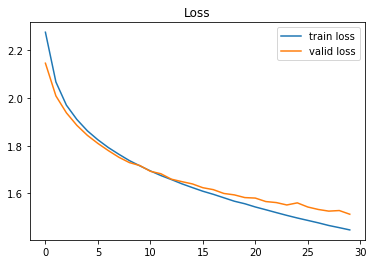

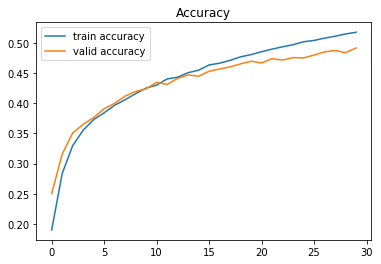



---------------- [ regularizer=l2(1e-2), w/o dropout, w/o BN ] ----------------


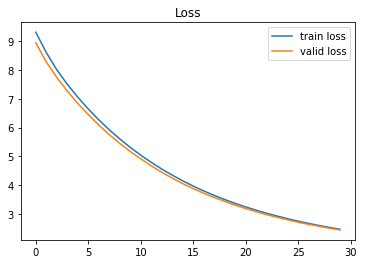

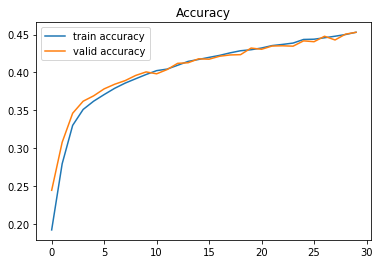



---------------- [ regularizer=l2(1e-4), w/  dropout, w/o BN ] ----------------


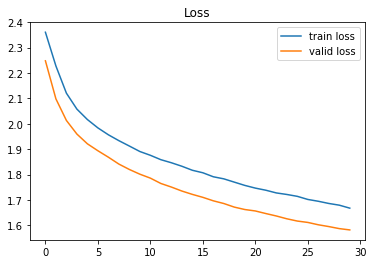

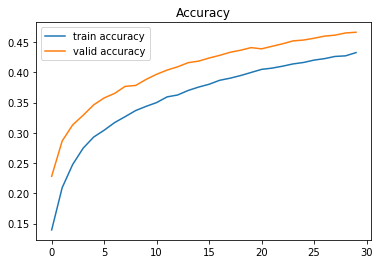



---------------- [ regularizer=l2(1e-2), w/  dropout, w/o BN ] ----------------


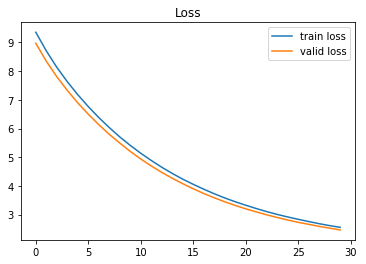

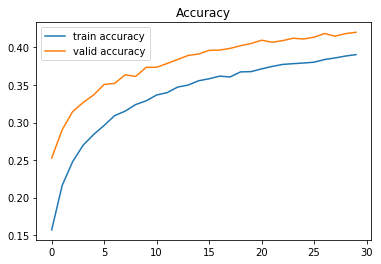



---------------- [ regularizer=l2(1e-4), w/o dropout, w/  BN ] ----------------


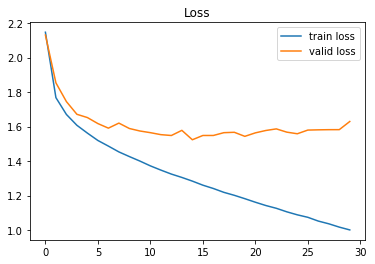

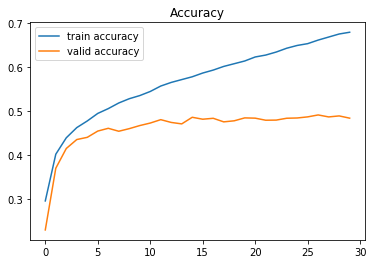



---------------- [ regularizer=l2(1e-2), w/o dropout, w/  BN ] ----------------


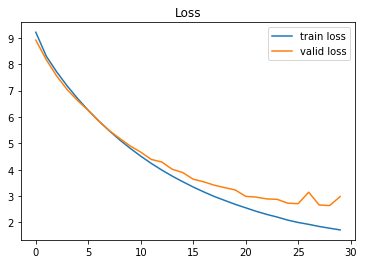

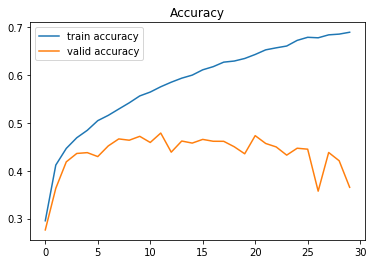



---------------- [ regularizer=l2(1e-4), w/  dropout, w/  BN ] ----------------


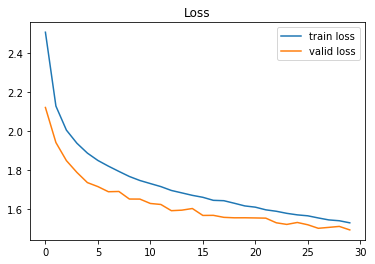

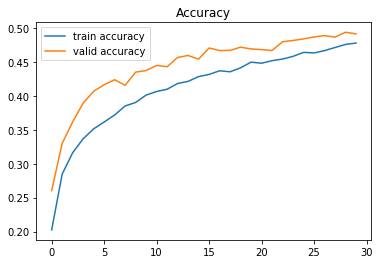



---------------- [ regularizer=l2(1e-2), w/  dropout, w/  BN ] ----------------


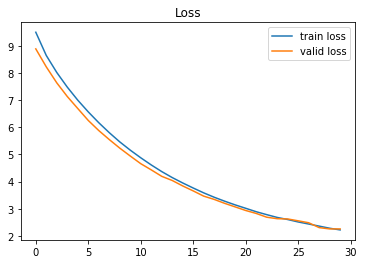

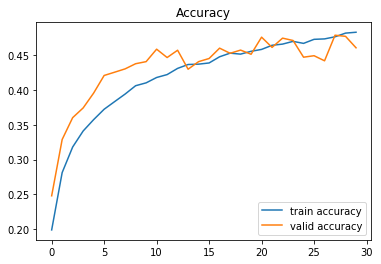

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
for key in results.keys():
    print("\n\n---------------- [ %s ] ----------------" % key)
    result = results[key]
    plt.plot(range(len(result["loss"])), result["loss"], label="train loss")
    plt.plot(range(len(result["val_loss"])), result["val_loss"], label="valid loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(range(len(result["accuracy"])), result["accuracy"], label="train accuracy")
    plt.plot(range(len(result["val_accuracy"])), result["val_accuracy"], label="valid accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()